# 06b - ANOVA to detect non-baseline msk and variable configurations with early signals of ACC
- author: Johannes L. Fjeldså
- email: johannes.larsen.fjeldså@nmbu.no

## Import libraries


In [1]:
from pathlib import Path
from src.preproces import *
from src.plotting import *
from src.create_masked_climatology import *
from src.heatmap import corrplot 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm import tqdm

from xclim import ensembles as ens
import pandas as pd
import xarray as xr
import re

file_handler = Handle_Files()

# Investigate Ensambles

Till now we have investigated advanced masking of: 'tas', 'pr', 'txxETCCDI', 'gslETCCDI', 'fdETCCDI', 'rx5dayETCCDI'. We have kept:
|                             	| **tas** 	| **pr** 	| **txxETCCDI** 	| **rx5dayETCCDI** 	| **gslETCCDI** 	| **fdETCCDI** 	|
|-----------------------------	|:-------:	|:------:	|:-------------:	|:----------------:	|:-------------:	|:------------:	|
| **nomask**                 	|    X    	|    X   	|       X       	|         X        	|       X       	|       X      	|
| **land_mask**              	|    X    	|    X   	|       X       	|         X        	|               	|              	|
| **sea_mask**                	|    X    	|    X   	|       X       	|         X        	|               	|              	|
| **lat_mask_30N_70N**       	|         	|        	|               	|                  	|       X       	|       X      	|
| **land_mask_30N_70N**      	|         	|        	|               	|                  	|       X       	|       X      	|
| **lat_mask_pm30deg**       	|         	|        	|       X       	|         X        	|               	|              	|
| **sea_mask_pm30deg**       	|         	|    X   	|       X       	|                  	|               	|              	|
| **pr_large_deviation_mask** 	|         	|    X   	|               	|         X        	|               	|              	|

In total we have 3375 combinations perform analysis on. 

In [2]:
def extract_realisation_number(file_name):
    match = re.search(r'r\d+', file_name)
    return int(match.group(0)[1:])

In [49]:
main_data_dir = '/nird/home/johannef/Masterthesis_S23 DataFiles/AnnualGlobalClimatologies'
mask_names = file_handler.get_all_filenames_in_dir(main_data_dir)
SSPs = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
data_frames = {scenario: {} for scenario in SSPs}

columns = []
for mask_name in mask_names:
    mask_data_dir = '/'.join([main_data_dir, mask_name])
    variables = file_handler.get_all_filenames_in_dir(mask_data_dir)
    for var in variables:
        columns.append(f'{var}: {mask_name}')

columns = sorted(columns, key=lambda x: (x.split(':')[0], x.split(':')[1]))
for scenario in SSPs:
    data_frames[scenario] = pd.DataFrame(columns=columns, index=range(1, 41))

for mask_name in mask_names:
    mask_data_dir = '/'.join([main_data_dir, mask_name])
    variables = file_handler.get_all_filenames_in_dir(mask_data_dir)

    for var in variables:

        for scenario in SSPs:
            data_dir = '/'.join([mask_data_dir, var, scenario])

            file_names = file_handler.get_all_netcdf_files_in_dir(data_dir)
            for file_name in file_names:
                indx = extract_realisation_number(file_name)
                ds = (
                    file_handler.read_netcdf_to_xr(directory=data_dir, file_name=file_name)
                    .sel(year=slice(2015, 2030))
                    .mean(dim='year')
                )
                data_frames[scenario].loc[indx, f'{var}: {mask_name}'] = ds[var].values.item()


# Investigate Correlation matrices

We will start by performing an anlysis of the correlation of varibales. The correlation betwenn varibles and masks will be taken within each SSP. A former analysis showed that there are some inter-year variation in the correlation matrices and so I use the mean value of baseline period of 2015-2030 in order to calculate the correlation matrix.

## Correlation matrix for each SSP

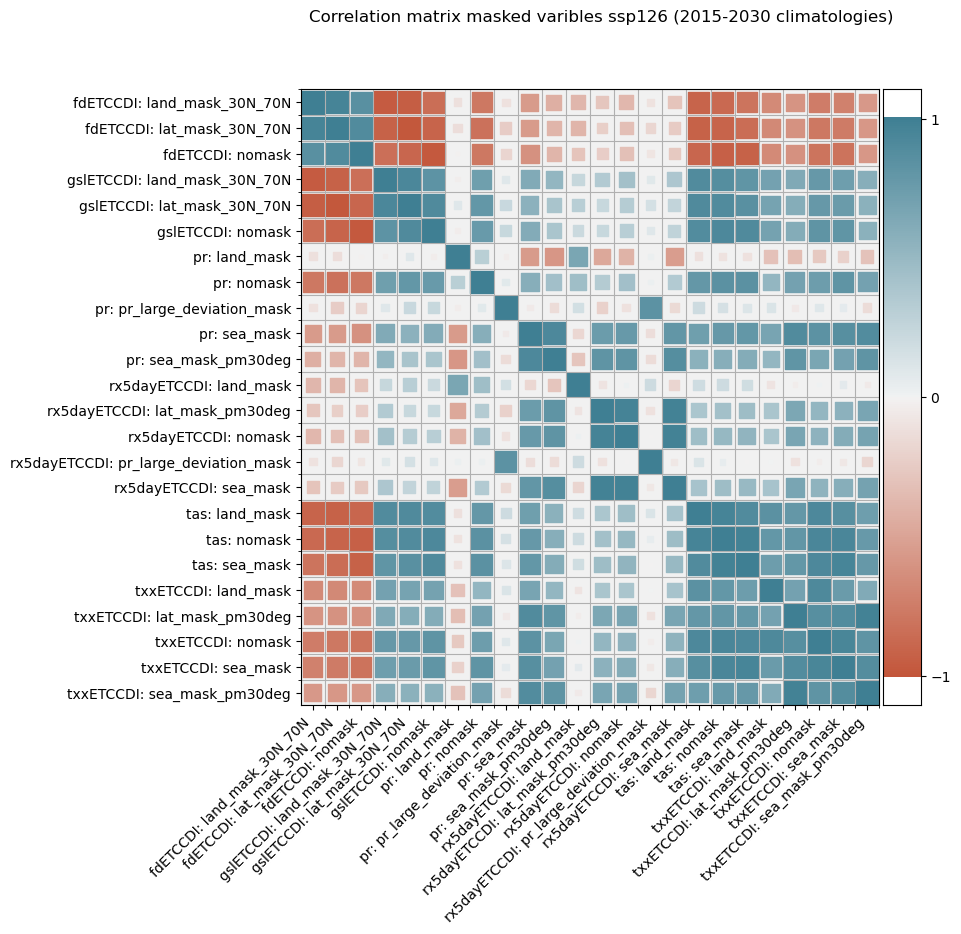

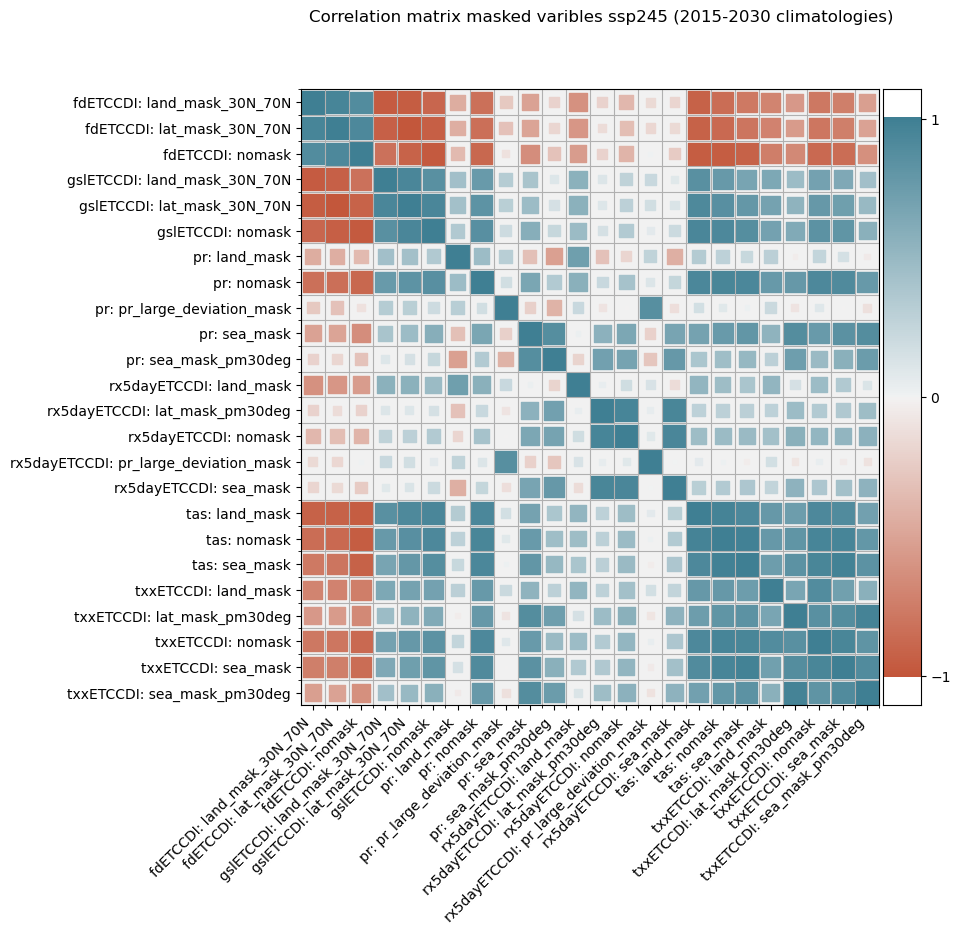

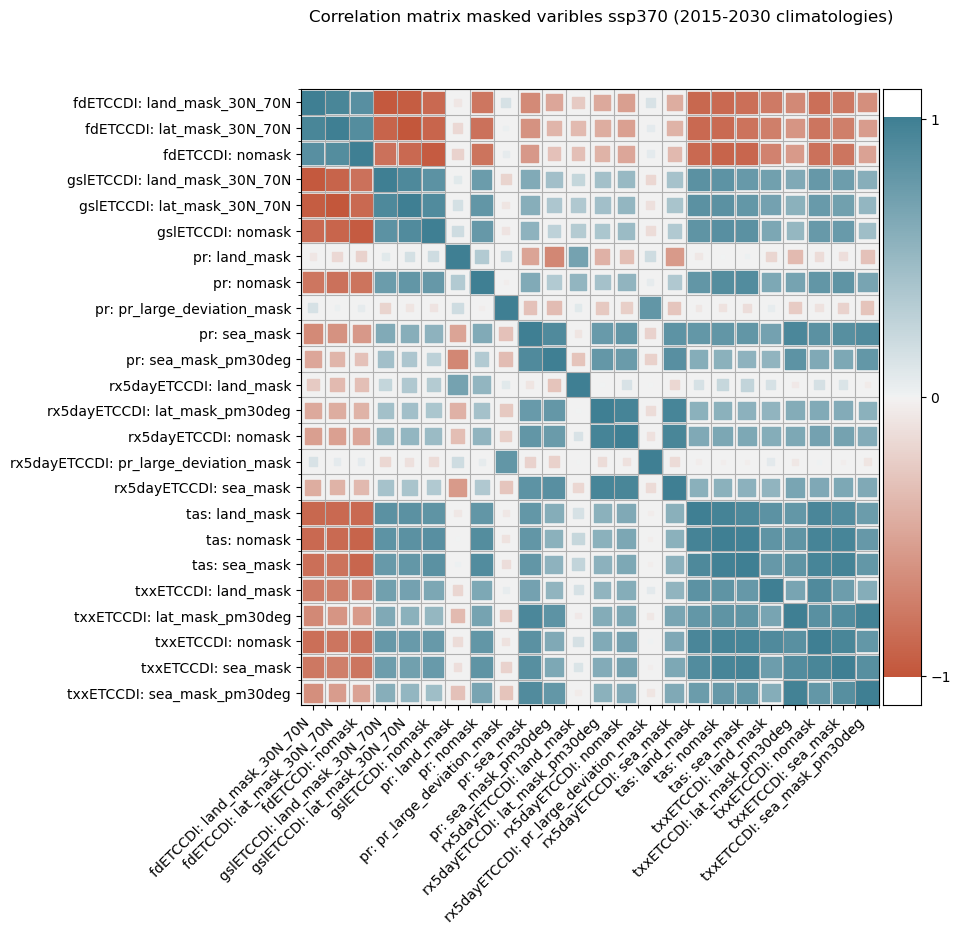

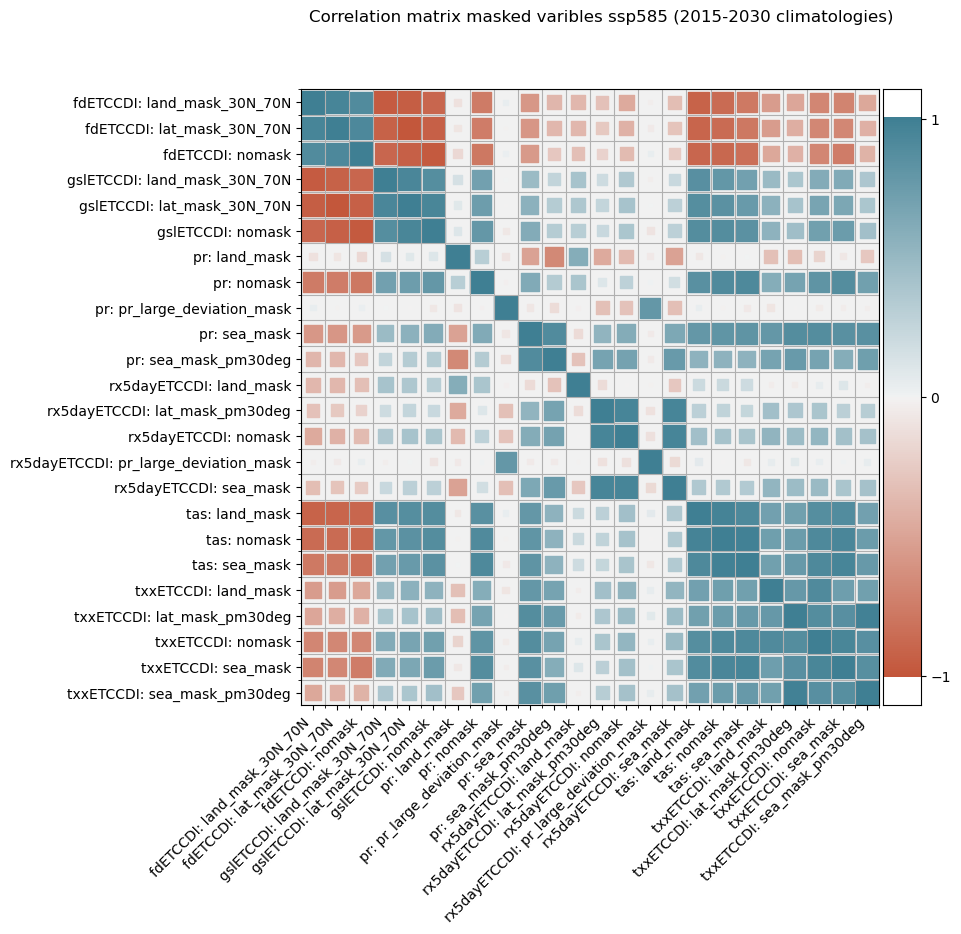

In [9]:
correlatin_matrices = {scenario: {} for scenario in SSPs}

for scenario in SSPs:
    scenario_df = data_frames[scenario]
        
    correlation_matrix = scenario_df.corr()
    correlatin_matrices[scenario] = correlation_matrix
    fig = plt.figure(figsize=(8, 8))
    fig.suptitle(f'Correlation matrix masked varibles {scenario} (2015-2030 climatologies)')
    corrplot(correlation_matrix, size_scale=265)
    plt.show()


## Investigate differences in correltion matrices from scenarios

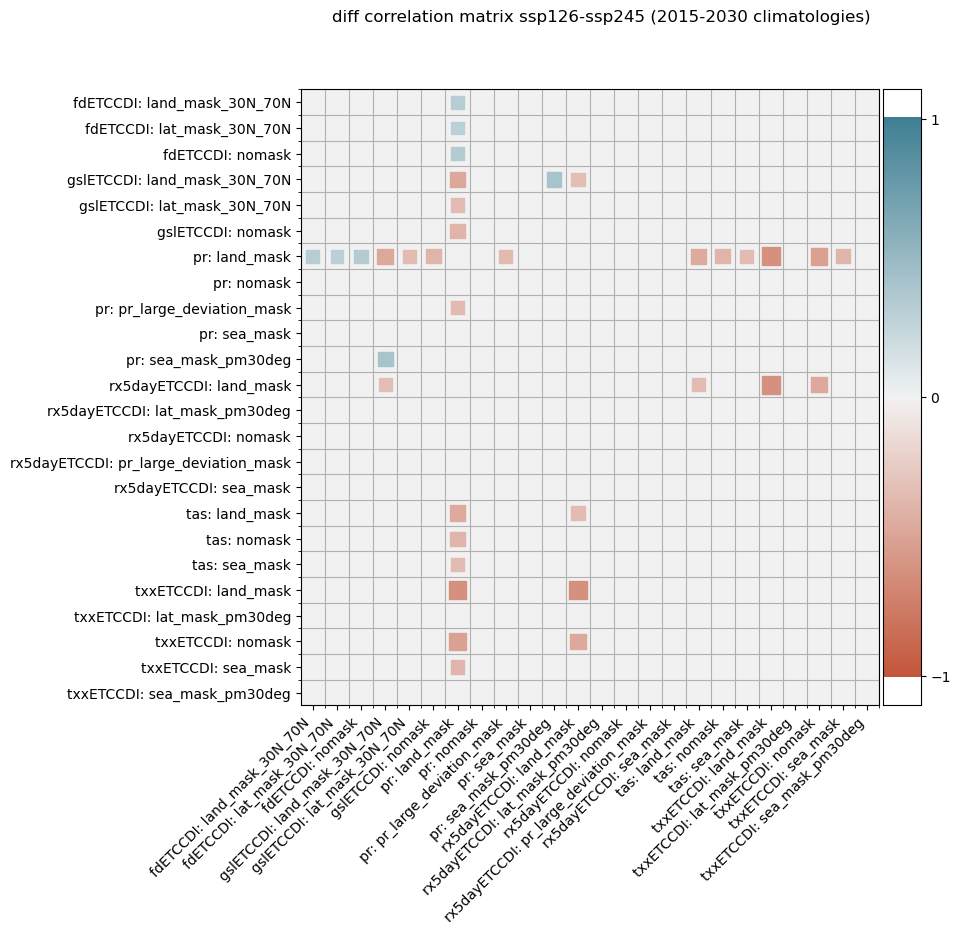

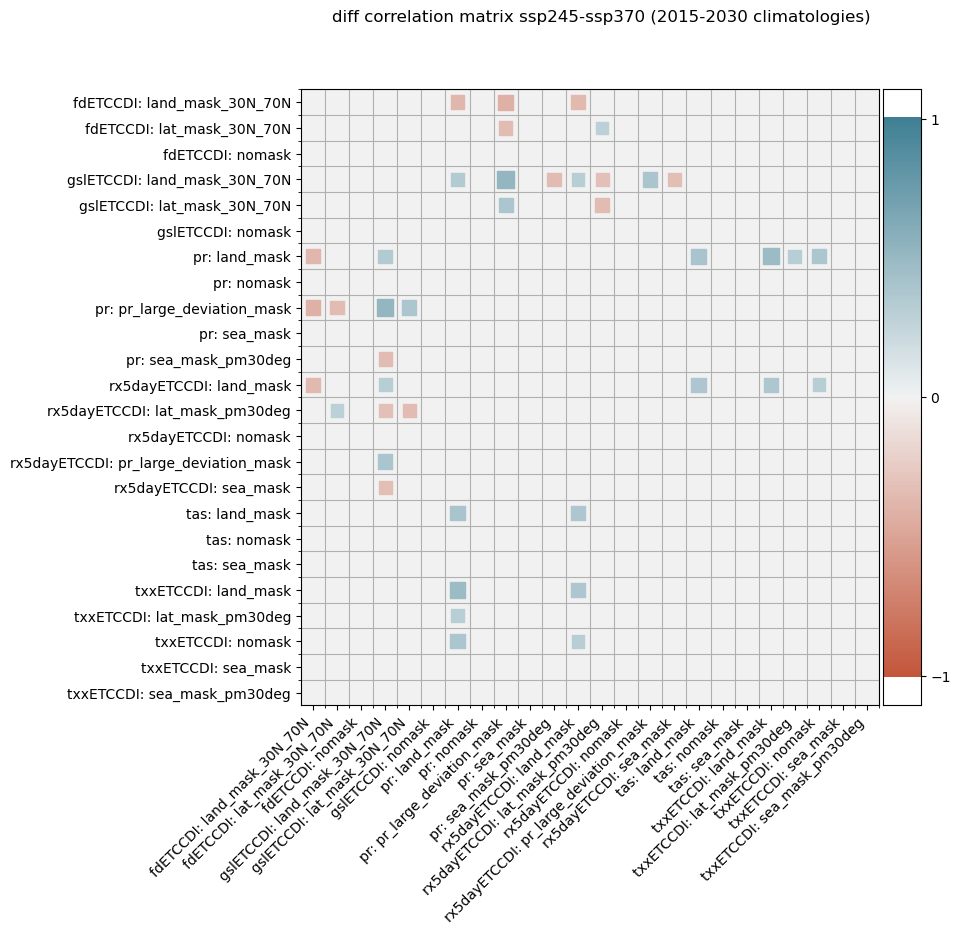

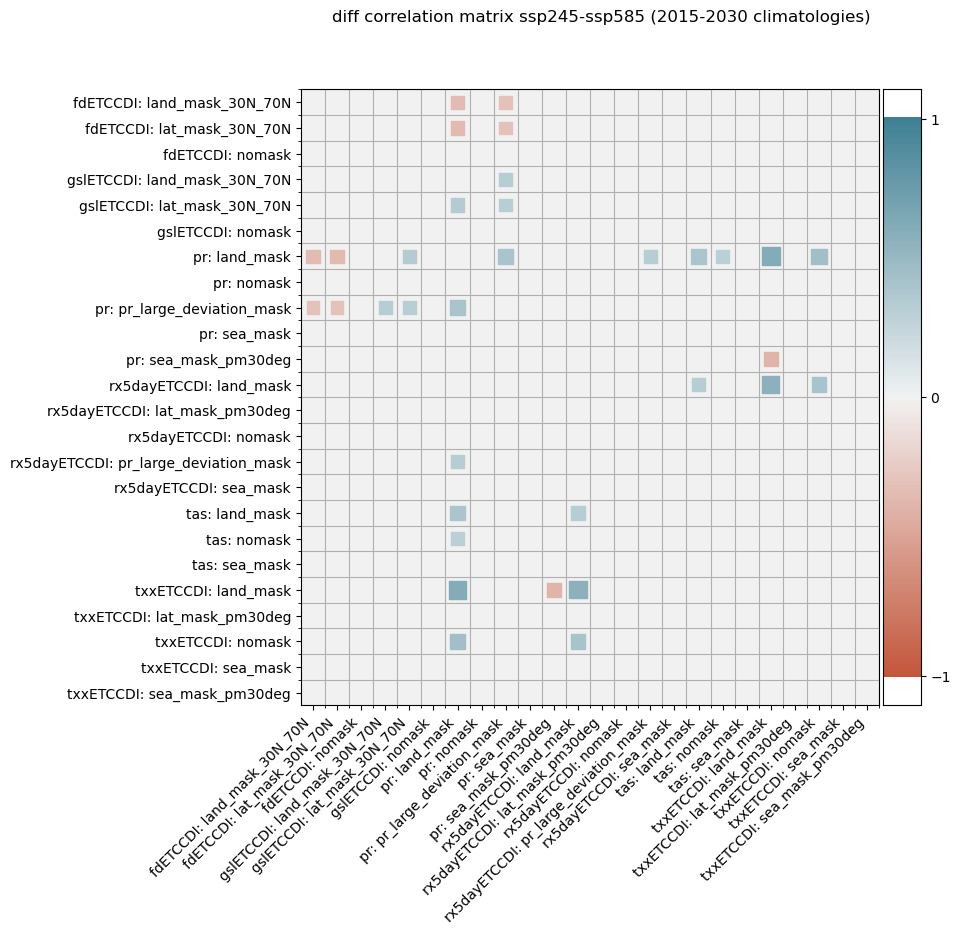

In [ ]:
used_combinations = []
for scenario in SSPs:
    other_scenarios = [item for item in SSPs if item != scenario]

    for other_scenario in other_scenarios:
        combination = tuple(sorted([scenario, other_scenario]))

        if combination not in used_combinations:
            diff = correlatin_matrices[scenario] - correlatin_matrices[other_scenario]
            max_diff = np.max(np.abs(diff))

            if max_diff >= 0.5:
                filtered_diff = diff.mask(np.abs(diff) < 0.3)                
                fig = plt.figure(figsize=(8, 8))
                fig.suptitle(f'diff correlation matrix {scenario}-{other_scenario} (2015-2030 climatologies)')
                corrplot(filtered_diff, size_scale=265)
                plt.show()   
            used_combinations.append(combination)
                 

## Correlation matrix across SSPs

The largest differences in correlation between SSPs is all related to precipitation variables. That is, no pair of non-precipitation variables has a larger difference in correltion then $|0.3|$ between SSPs. The differences is relatively small for most 'var: mask' combinations between SSPs. We therefor use the mean across 2015-2030 and include all SSPs in the table for correlation matrix calculation.

In [50]:

scenario_indx_key = {'ssp126': 1, 'ssp245': 2, 'ssp370': 3, 'ssp585': 4}

# add SSP as column for each df
for scenario, df in data_frames.items():
    df['scenario'] = scenario
    df['scenario_indx'] = scenario_indx_key[scenario]
    df = df.reindex(columns=['scenario', 'scenario_indx'] + [col for col in df.columns if col not in ['scenario', 'scenario_indx']])
    data_frames[scenario] = df

# concat the dfs vertically
all_SSPs_df = pd.concat(data_frames.values())
all_SSPs_df.head()

,scenario,scenario_indx,fdETCCDI: land_mask_30N_70N,fdETCCDI: lat_mask_30N_70N,fdETCCDI: nomask,gslETCCDI: land_mask_30N_70N,gslETCCDI: lat_mask_30N_70N,gslETCCDI: nomask,pr: land_mask,pr: nomask,...,rx5dayETCCDI: pr_large_deviation_mask,rx5dayETCCDI: sea_mask,tas: land_mask,tas: nomask,tas: sea_mask,txxETCCDI: land_mask,txxETCCDI: lat_mask_pm30deg,txxETCCDI: nomask,txxETCCDI: sea_mask,txxETCCDI: sea_mask_pm30deg
1,ssp126,1,146.772039,94.236957,55.939877,198.767694,246.69988,293.3192,0.000029,0.000038,...,107.204499,115.447787,283.716945,288.936232,291.043994,32.796525,32.254317,25.93496,23.16101,28.983077
2,ssp126,1,146.934256,94.691248,55.26968,198.491213,245.714622,293.805748,0.000029,0.000038,...,102.47749,114.530695,283.747235,288.970654,291.079518,32.79148,32.284426,25.951137,23.181019,28.998871
3,ssp126,1,149.609471,97.378466,56.334064,195.917752,243.541949,292.89515,0.000029,0.000038,...,102.253429,115.108795,283.560354,288.874035,291.021128,32.639545,32.175792,25.872307,23.132517,28.934642
4,ssp126,1,148.079206,96.154432,56.624984,196.839083,244.35289,292.737836,0.000029,0.000038,...,105.84114,113.511676,283.591963,288.8284,290.945455,32.640673,32.126102,25.81962,23.056179,28.883665
5,ssp126,1,145.66035,93.818785,55.532562,198.892771,246.778261,293.437963,0.000029,0.000038,...,103.456398,113.7018,283.712652,288.943944,291.055204,32.638831,32.240713,25.887856,23.151643,28.969105


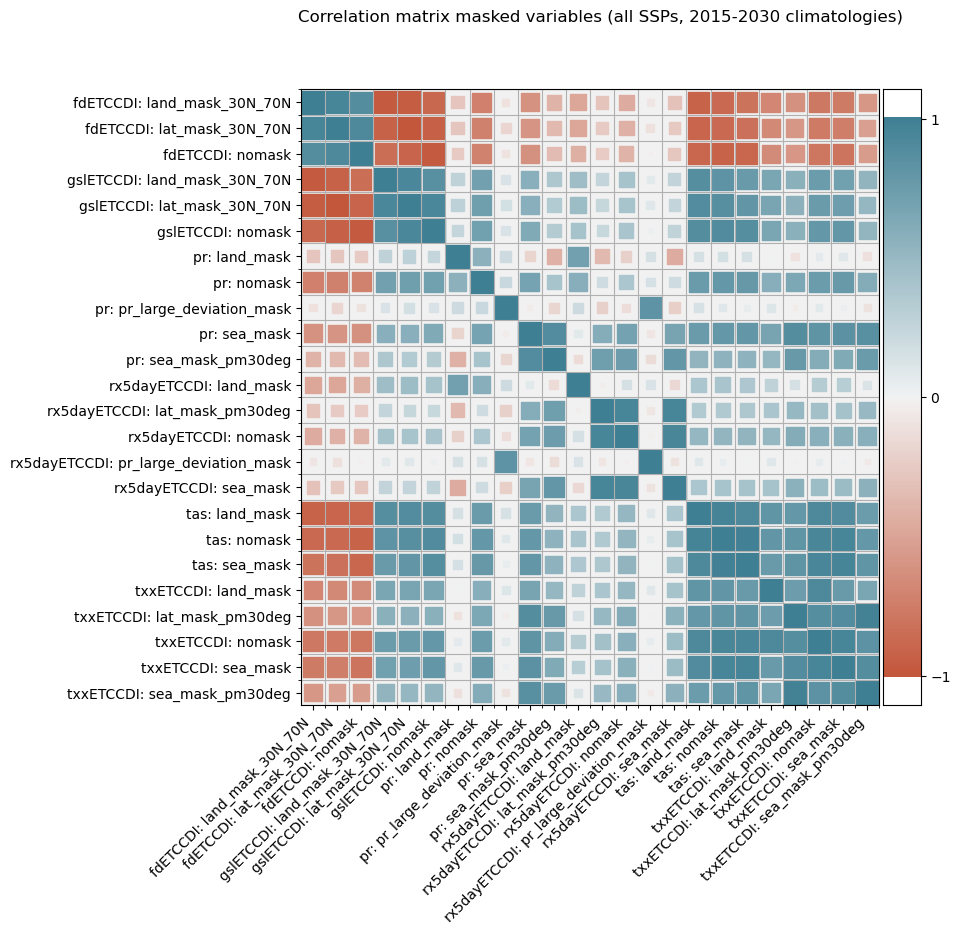

In [57]:
correlation_matrix = all_SSPs_df[[col for col in all_SSPs_df.columns if col not in ['scenario', 'scenario_indx']]].corr()
fig = plt.figure(figsize=(8, 8))
fig.suptitle(f'Correlation matrix masked variables (all SSPs, 2015-2030 climatologies)')
corrplot(correlation_matrix, size_scale=265)
plt.show()


The high correlation found within each variables (outlined bellow) suggest that it is not wise to include features from the same variable as ML models often expect independent features. An exeption can maby be made within the precipitation masks as these has lower correlation. The features concerned witht temperature (tas and txx) might leed to problems in combinations, this is also true for fd-gsl combinations. This will be handled by built in regularisation in the ML models. 

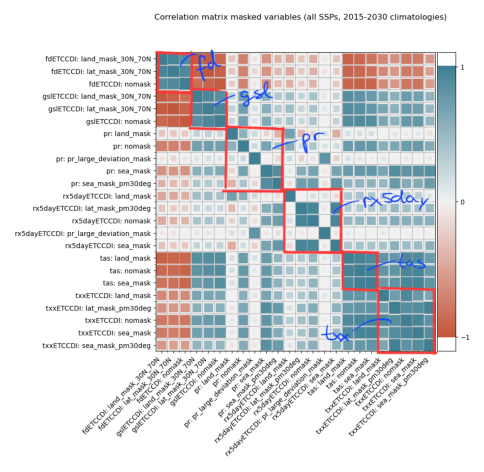

In [61]:
disp_external_fig('/nird/home/johannef/Masterthesis_S23/External figs/correlation_matrix_allvarmaskcombs_allSSPs_2015-2030clim.png', wanted_height=6)

# Feature selection

In [3]:
from sklearn.preprocessing import StandardScaler

We have to start by extracting cross sections for the range of years: 2015-2060

In [4]:
# NB takes a long time to run, import from '/nird/home/johannef/Masterthesis_S23 DataFiles/tables/cross_sections/' instead
main_data_dir = '/nird/home/johannef/Masterthesis_S23 DataFiles/AnnualGlobalClimatologies'
mask_names = file_handler.get_all_filenames_in_dir(main_data_dir)
SSPs = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
#scenario_indx_key = {'ssp126': 1, 'ssp245': 2, 'ssp370': 3, 'ssp585': 4}

years = list(range(2015, 2101))
data_frames = {year: {} for year in years}


columns = []
for mask_name in mask_names:
    mask_data_dir = '/'.join([main_data_dir, mask_name])
    variables = file_handler.get_all_filenames_in_dir(mask_data_dir)
    for var in variables:
        columns.append(f'{var}: {mask_name}')

columns = sorted(columns, key=lambda x: (x.split(':')[0], x.split(':')[1]))

for year in years:
    for scenario in SSPs:
        data_frames[year][scenario] = pd.DataFrame(columns=columns, index=range(1, 41))
        data_frames[year][scenario]['scenario'] = scenario
        #data_frames[year][scenario]['scenario_indx'] = scenario_indx_key[scenario]

for year in tqdm(years):
    for mask_name in mask_names:
        mask_data_dir = '/'.join([main_data_dir, mask_name])
        variables = file_handler.get_all_filenames_in_dir(mask_data_dir)

        for var in variables:

            for scenario in SSPs:
                data_dir = '/'.join([mask_data_dir, var, scenario])

                file_names = file_handler.get_all_netcdf_files_in_dir(data_dir)
                for file_name in file_names:
                    indx = extract_realisation_number(file_name)
                    ds = (
                        file_handler.read_netcdf_to_xr(directory=data_dir, file_name=file_name)
                        .sel(year=year)
                    )
                    data_frames[year][scenario].loc[indx, f'{var}: {mask_name}'] = ds[var].values.item()

save_folder = '/nird/home/johannef/Masterthesis_S23 DataFiles/tables/cross_sections/unscaled'
save_folder_scaled = '/nird/home/johannef/Masterthesis_S23 DataFiles/tables/cross_sections/standardscaled'

features = [col for col in data_frames[2015]['ssp126'].columns if col not in ['scenario']]
scaler = StandardScaler()

for year in years:
    all_SSPs_df = pd.concat(data_frames[year].values(), ignore_index=True)
    all_SSPs_df.to_csv('/'.join([save_folder, f'cross_section_{year}.csv']), index=False)

    all_SSPs_df_scaled = all_SSPs_df
    all_SSPs_df_scaled[features] = scaler.fit_transform(all_SSPs_df_scaled[features])
    all_SSPs_df_scaled.to_csv('/'.join([save_folder_scaled, f'cross_section_{year}_standscaled.csv']), index=False)

100%|██████████| 86/86 [11:23<00:00,  7.94s/it]


Now we can import the tables from '/nird/home/johannef/Masterthesis_S23 DataFiles/tables/cross_sections'

## Using minimum redundancy maximum relevance (mRMR) algorithm 

mRMR is a multivariate filter method, that is, it ranks the feature importance withou using a classification algorithm. It also consider feature interactions as it assess feature correlations also. The interpretation of the mRMR output base on [this article](https://towardsdatascience.com/mrmr-explained-exactly-how-you-wished-someone-explained-to-you-9cf4ed27458b):

- **Relevance**: The algorithm identifies features that have a high correlation or mutual information with the target variable. These features are considered relevant for predicting or explaining the target variable.
- **Redundancy**: mRMR aims to select features that are dissimilar or minimally redundant with each other. This helps in capturing unique information from each selected feature without unnecessary overlap.
- **Feature Selection**: The output of mRMR typically provides a ranking or selection of features based on their relevance and redundancy scores. Features with high relevance and low redundancy are ranked higher in importance for predicting the target variable.
- **Optimal Subset**: mRMR aims to find an optimal subset of features that collectively maximize relevance to the target variable while minimizing redundancy among the selected features. This subset is crucial for building accurate predictive models.

To run alg the documentation is found [here](https://pypi.org/project/mrmr-selection/)

In [2]:
import pandas as pd
from mrmr import mrmr_classif
from tqdm import tqdm
from src.plotting import *

In [3]:
years = list(range(2015, 2101))
scaled_cross_sections = {year: pd.read_csv('/'.join(['/nird/home/johannef/Masterthesis_S23 DataFiles/tables/cross_sections/standardscaled', f'cross_section_{year}_standscaled.csv'])) for year in years}
cross_sections = {year: pd.read_csv('/'.join(['/nird/home/johannef/Masterthesis_S23 DataFiles/tables/cross_sections/unscaled', f'cross_section_{year}.csv'])) for year in years}

In [4]:
scs_126585 = {}
cs_126585 = {}
for year in years:
    scaled_cross_section = scaled_cross_sections[year]
    scs_126585[year] = scaled_cross_section[scaled_cross_section['scenario'].isin(['ssp126', 'ssp585'])]
    cross_section = cross_sections[year]
    cs_126585[year] = cross_section[cross_section['scenario'].isin(['ssp126', 'ssp585'])]

In [8]:
features = [col for col in scaled_cross_sections[2015].columns if col not in ['scenario']]
mRMR_scores_df = pd.DataFrame(columns=['year']+features, index=range(len(years)))
for indx, year in tqdm(enumerate(years)):
    #cross_section_df = scaled_cross_sections[year]
    cross_section_df = scs_126585[year]
    X = cross_section_df[features]
    y = cross_section_df['scenario']
    
    mRMR_results = mrmr_classif(X, y,
                                K=10, return_scores=True, show_progress=False)
    mRMR_scores_df.loc[indx] = [year] + mRMR_results[1].tolist()


#mRMR_scores_df.to_csv('/nird/home/johannef/Masterthesis_S23 DataFiles/tables/feature_selection/mRMR_scores_scaled.csv', index=False)
mRMR_scores_df.to_csv('/nird/home/johannef/Masterthesis_S23 DataFiles/tables/feature_selection/mRMR_scores_scaled_ssp126ssp585.csv', index=False)

86it [06:32,  4.56s/it]


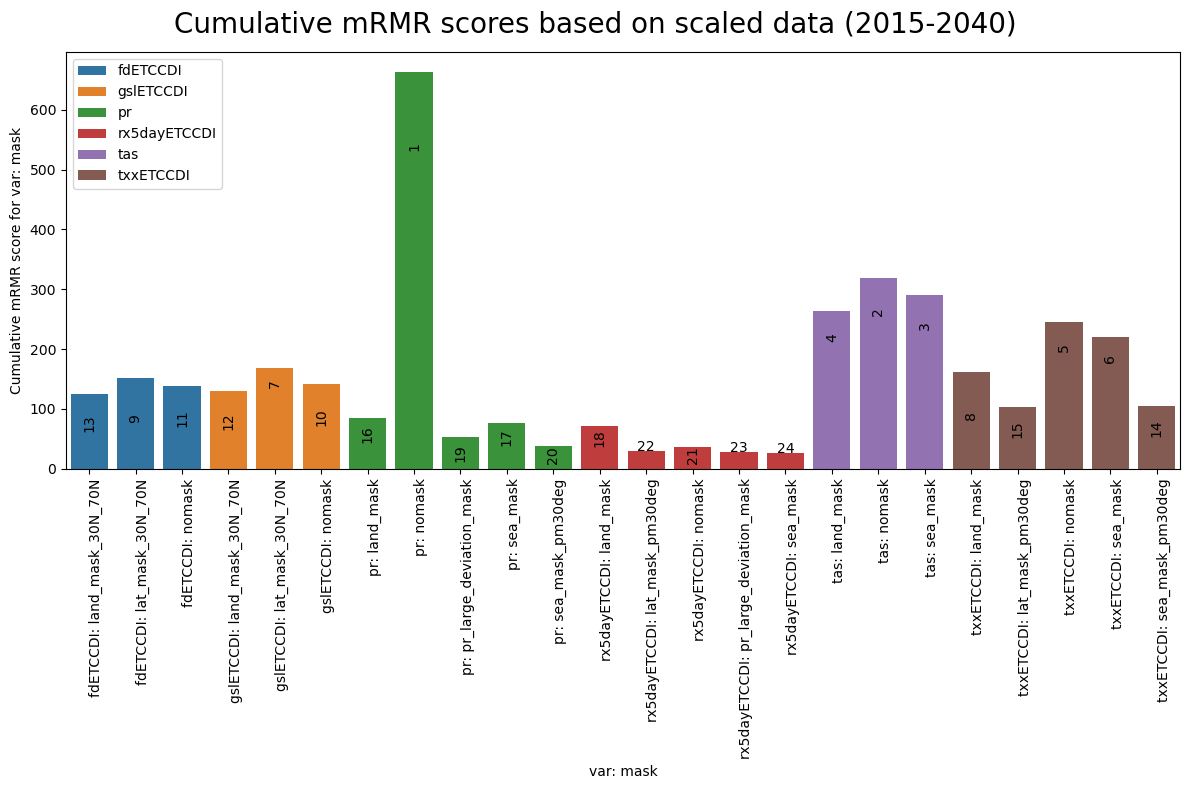

In [4]:
mRMR_scores_df_scaled = pd.read_csv('/nird/home/johannef/Masterthesis_S23 DataFiles/tables/feature_selection/mRMR_scores_scaled.csv')
plot_cumulative_mRMR_scores(mRMR_scores_df_scaled, title='Cumulative mRMR scores based on scaled data (2015-2040)',
                            filter_name='mRMR',
                            period=(2015, 2040),
                            save=True, 
                            save_name='cumulative_mRMR_scores_2015to2040.png')

animate_scores_barplot(mRMR_scores_df_scaled, title=f'Cumulative mRMR-scores', filter_name='mRMR', 
                       save_name=f'mRMR_scores_animation.gif')

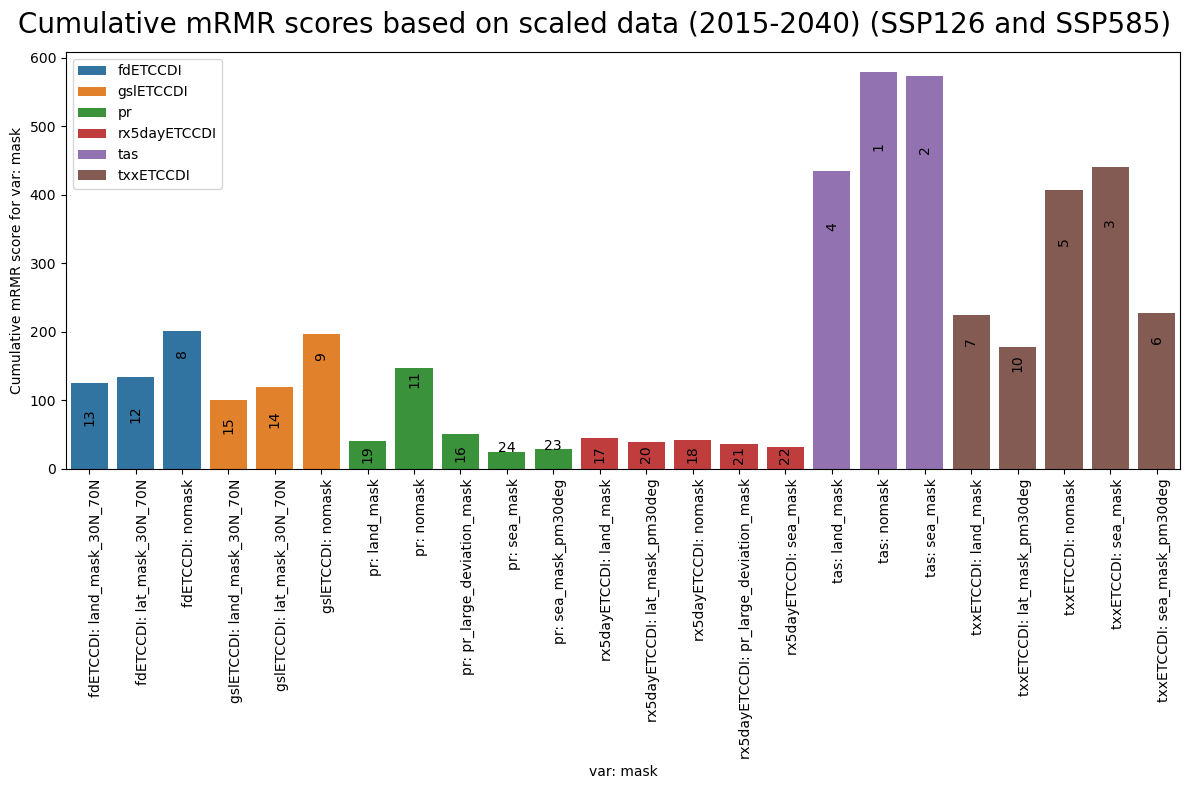

In [9]:
mRMR_scores_df_scaled = pd.read_csv('/nird/home/johannef/Masterthesis_S23 DataFiles/tables/feature_selection/mRMR_scores_scaled_ssp126ssp585.csv')
plot_cumulative_mRMR_scores(mRMR_scores_df_scaled, title='Cumulative mRMR scores based on scaled data (2015-2040) (SSP126 and SSP585)',
                            filter_name='mRMR',
                            period=(2015, 2040),
                            save=True, 
                            save_name='cumulative_mRMR_scores_2015to2040_ssp126andssp585.png')

animate_scores_barplot(mRMR_scores_df_scaled, title=f'Cumulative mRMR-scores (SSP126 and SSP585)', filter_name='mRMR', 
                       save_name=f'mRMR_scores_animation_ssp126andssp585.gif')

## Using ridge regression coeffisients

Ridge regression coefficients can be used for feature selection by examining the magnitude of the coefficients. Features with higher coefficients in ridge regression are considered more important in predicting the target variable. You can use ridge regression coefficients for feature selection using :
- Absolute Coefficient Values: Calculate the absolute values of the ridge regression coefficients. Larger absolute values indicate more important features.
- Thresholding: Set a threshold value and select features with coefficients above this threshold. Features with coefficients exceeding the threshold are considered significant.

In [5]:
from sklearn.linear_model import RidgeCV

In [10]:
features = [col for col in scaled_cross_sections[2015].columns if col not in ['scenario']]
ridge_importance_df = pd.DataFrame(columns=['year']+features, index=range(len(years)))

for indx, year in tqdm(enumerate(years)):
    #cross_section_df = scaled_cross_sections[year]
    cross_section_df = scs_126585[year]
    X = cross_section_df[features]
    y = pd.get_dummies(cross_section_df['scenario'])
    
    ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X, y)

    importance_per_scenario = np.abs(ridge.coef_)
    importance = [sum(items) for items in zip(*importance_per_scenario)]
    ridge_importance_df.loc[indx] = [year] + importance

#ridge_importance_df.to_csv('/nird/home/johannef/Masterthesis_S23 DataFiles/tables/feature_selection/ridge_importance_onehot.csv', index=False)
ridge_importance_df.to_csv('/nird/home/johannef/Masterthesis_S23 DataFiles/tables/feature_selection/ridge_importance_onehot_ssp126ssp585.csv', index=False)

86it [00:00, 360.62it/s]


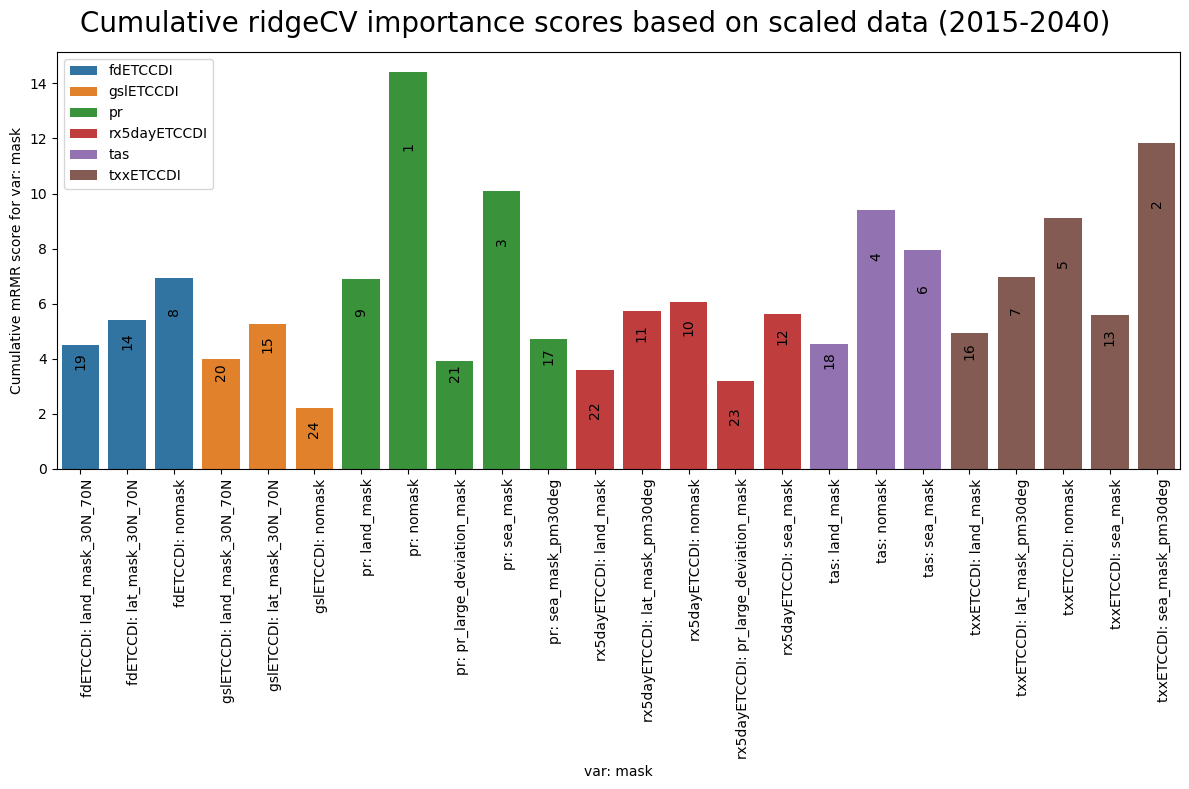

In [11]:
ridge_importance_df = pd.read_csv('/nird/home/johannef/Masterthesis_S23 DataFiles/tables/feature_selection/ridge_importance_onehot.csv')
plot_cumulative_mRMR_scores(ridge_importance_df, title='Cumulative ridgeCV importance scores based on scaled data (2015-2040)',
                            filter_name='ridgeCVimportance',
                            period=(2015, 2040),
                            save=True, 
                            save_name='cumulative_ridgeCVimportance_scores_2015to2040.png')

animate_scores_barplot(ridge_importance_df, title=f'Cumulative ridgeCV importance scores', filter_name='ridgeCVimportance', 
                       save_name=f'ridgeCVimportance_scores_animation.gif')

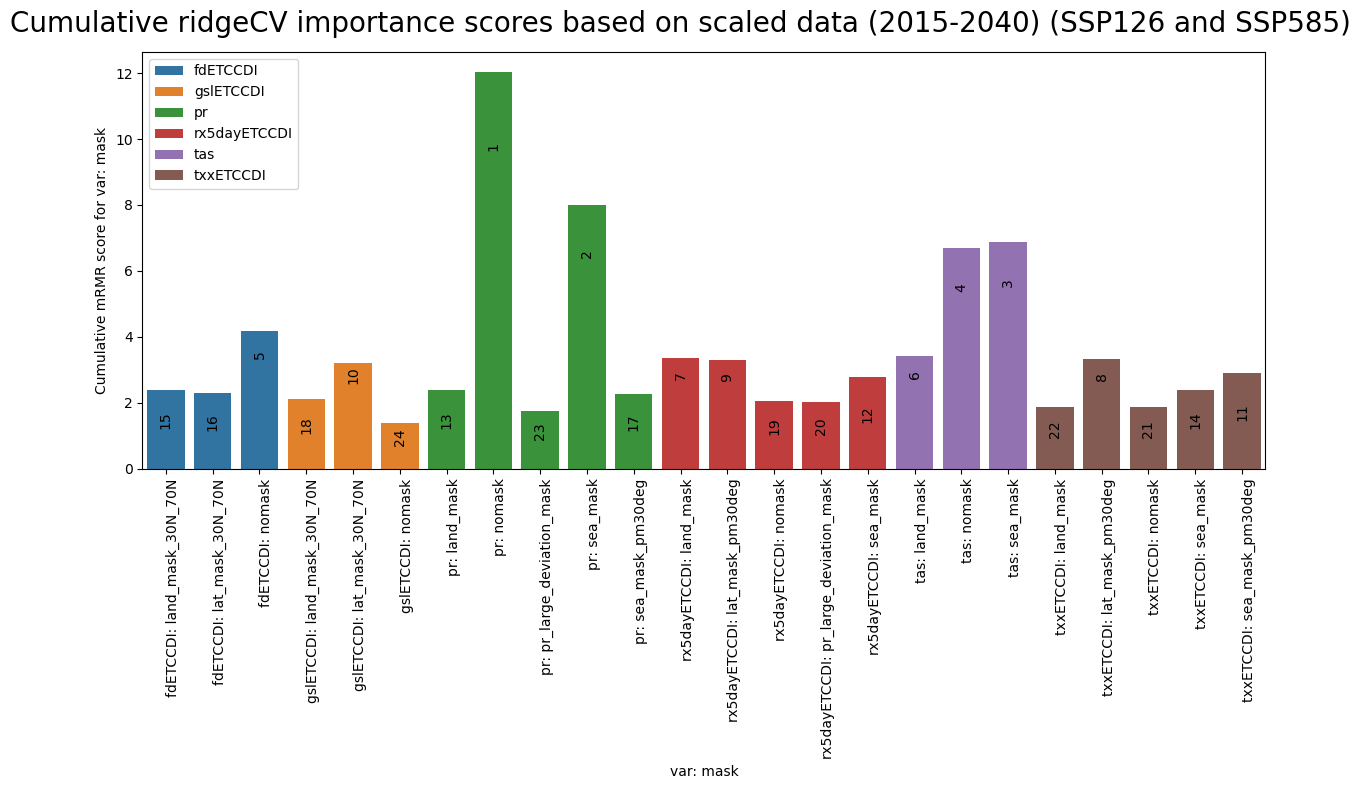

In [12]:
ridge_importance_df = pd.read_csv('/nird/home/johannef/Masterthesis_S23 DataFiles/tables/feature_selection/ridge_importance_onehot_ssp126ssp585.csv')
plot_cumulative_mRMR_scores(ridge_importance_df, title='Cumulative ridgeCV importance scores based on scaled data (2015-2040) (SSP126 and SSP585)',
                            filter_name='ridgeCVimportance',
                            period=(2015, 2040),
                            save=True, 
                            save_name='cumulative_ridgeCVimportance_scores_2015to2040_ssp126andssp585.png')

animate_scores_barplot(ridge_importance_df, title=f'Cumulative ridgeCV importance scores (SSP126 and SSP585)', filter_name='ridgeCVimportance', 
                       save_name=f'ridgeCVimportance_scores_animation_ssp126andssp585.gif')

## Using Sequential Feature Selection (SFS) (NOT PERFORMED)

(description from [sklearn](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection))

SFS can be runned either forward or backward:
- **Forward-SFS** is a greedy procedure that iteratively finds the best new feature to add to the set of selected features. Concretely, we initially start with zero features and find the one feature that maximizes a cross-validated score when an estimator is trained on this single feature. Once that first feature is selected, we repeat the procedure by adding a new feature to the set of selected features. The procedure stops when the desired number of selected features is reached, as determined by the n_features_to_select parameter.
- **Backward-SFS** follows the same idea but works in the opposite direction: instead of starting with no features and greedily adding features, we start with all the features and greedily remove features from the set. The direction parameter controls whether forward or backward SFS is used.

How to run is found [here](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py). We have to choose the Ridge_cv estimator to grasp the importance of variables. 

## Using univariate filter methods (f-score, mutual information)

The f-score filter method meassures the differences between the ditributions given the scenarios (SSPs). It is based on the univariate ANOVA (one way anova) test and thus does NOT consider feature interactions when filtering. Central assumptions is that the feature ough to be normally distributed with the same variance. The figure in '06 - Variance analysis to detect SSP differences early.ipynb' under the header MANOVA adequacy checking show few violations for the shapiro wilks test and thus I consider the assumption to be met here. Note however that the shapiro-wilks test is only performed for 'nomask', 'land_mask' and 'sea_mask' climatologies. The higher f_value indicate a more important feature.

In [14]:
from sklearn.feature_selection import f_classif, mutual_info_classif

In [15]:
features = [col for col in scaled_cross_sections[2015].columns if col not in ['scenario']]
f_score_df = pd.DataFrame(columns=['year']+features, index=range(len(years)))
mut_info_score_df = pd.DataFrame(columns=['year']+features, index=range(len(years)))

for indx, year in tqdm(enumerate(years)):
    #cross_section_df = scaled_cross_sections[year]
    cross_section_df = scs_126585[year]
    X = cross_section_df[features]
    y = cross_section_df['scenario'].astype('category')
    
    f_scores, f_p_value = f_classif(X,y)
    f_scores = f_scores.tolist()
    f_scores.insert(0, year)
    f_score_df.loc[indx] = f_scores

    mut_info_score = mutual_info_classif(X,y)
    mut_info_score = mut_info_score.tolist()
    mut_info_score.insert(0, year)
    mut_info_score_df.loc[indx] = mut_info_score

#f_score_df.to_csv('/nird/home/johannef/Masterthesis_S23 DataFiles/tables/feature_selection/f_scores.csv', index=False)
#mut_info_score_df.to_csv('/nird/home/johannef/Masterthesis_S23 DataFiles/tables/feature_selection/mut_info_scores.csv', index=False)
f_score_df.to_csv('/nird/home/johannef/Masterthesis_S23 DataFiles/tables/feature_selection/f_scores_ssp126ssp585.csv', index=False)
mut_info_score_df.to_csv('/nird/home/johannef/Masterthesis_S23 DataFiles/tables/feature_selection/mut_info_scores_ssp126ssp585.csv', index=False)

86it [00:02, 30.75it/s]


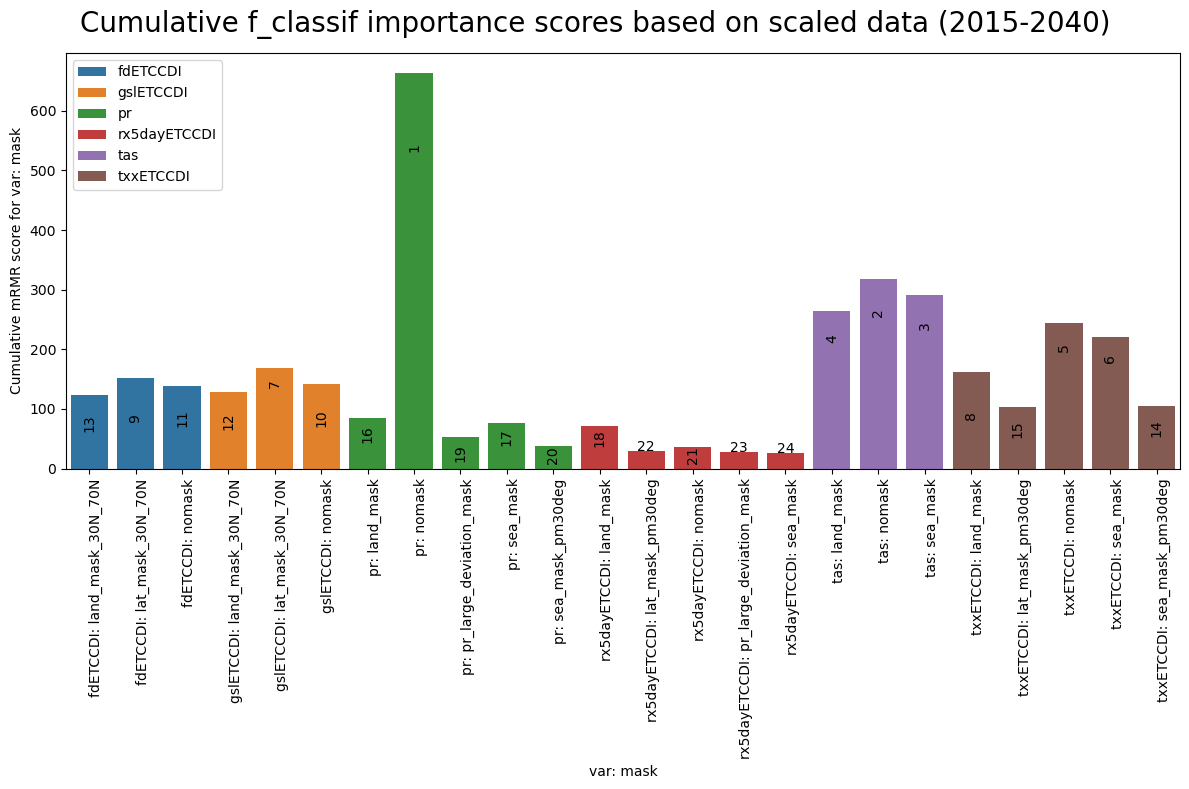

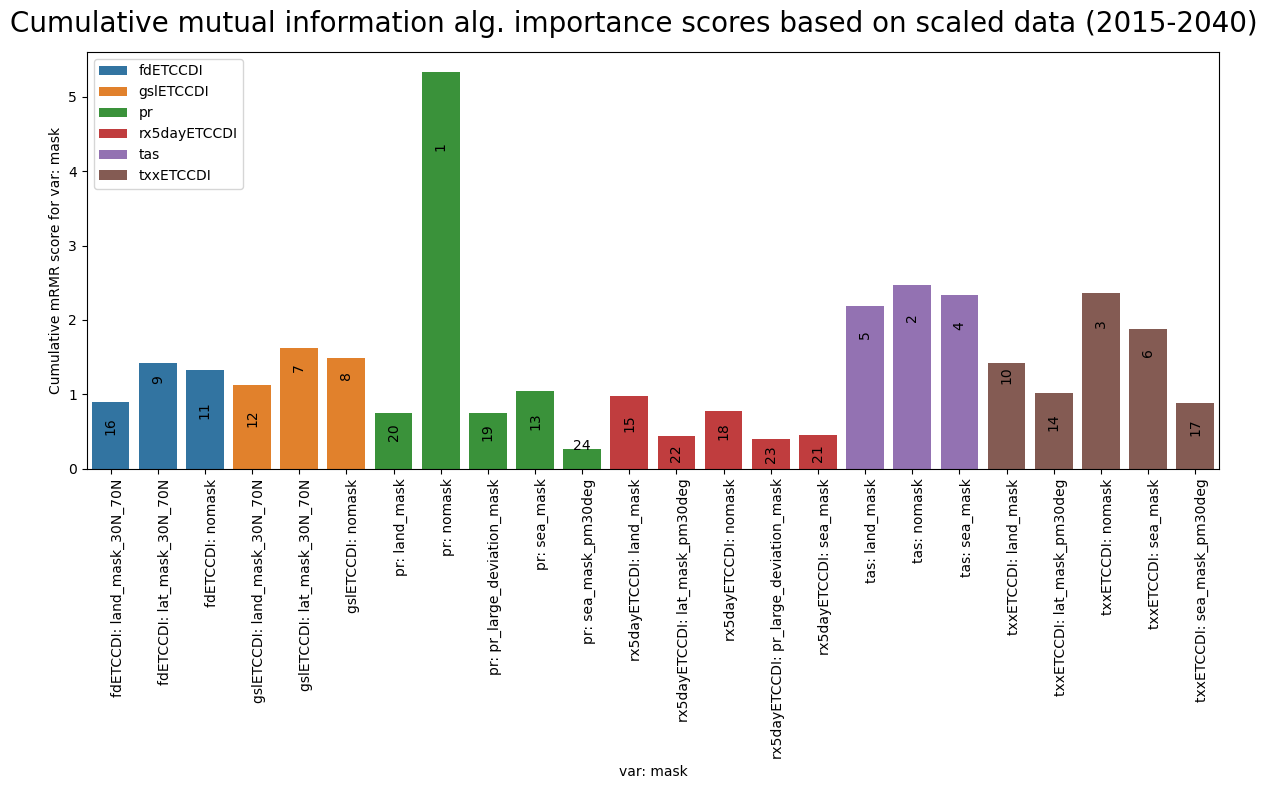

In [16]:
f_score_df = pd.read_csv('/nird/home/johannef/Masterthesis_S23 DataFiles/tables/feature_selection/f_scores.csv')
mut_info_score_df = pd.read_csv('/nird/home/johannef/Masterthesis_S23 DataFiles/tables/feature_selection/mut_info_scores.csv')

plot_cumulative_mRMR_scores(f_score_df, period=(2015, 2040), 
                            title='Cumulative f_classif importance scores based on scaled data (2015-2040)', 
                            filter_name='f_classif',
                            save=True, 
                            save_name='cumulative_f_classifimportance_scores_2015to2040.png')
animate_scores_barplot(f_score_df, 
                       title=f'Cumulative f_classif importance scores', 
                       filter_name='f_classif', 
                       save_name=f'f_classif_scores_animation.gif')
plot_cumulative_mRMR_scores(mut_info_score_df, period=(2015, 2040), 
                            title='Cumulative mutual information alg. importance scores based on scaled data (2015-2040)',
                            filter_name='mutual_info',
                            save=True,
                            save_name='cumulative_mutualinfoimportance_scores_2015to2040.png')
animate_scores_barplot(mut_info_score_df, 
                       title=f'Cumulative mutual information alg. importance scores', 
                       filter_name='mutual_info', 
                       save_name=f'mutual_info_scores_animation.gif')

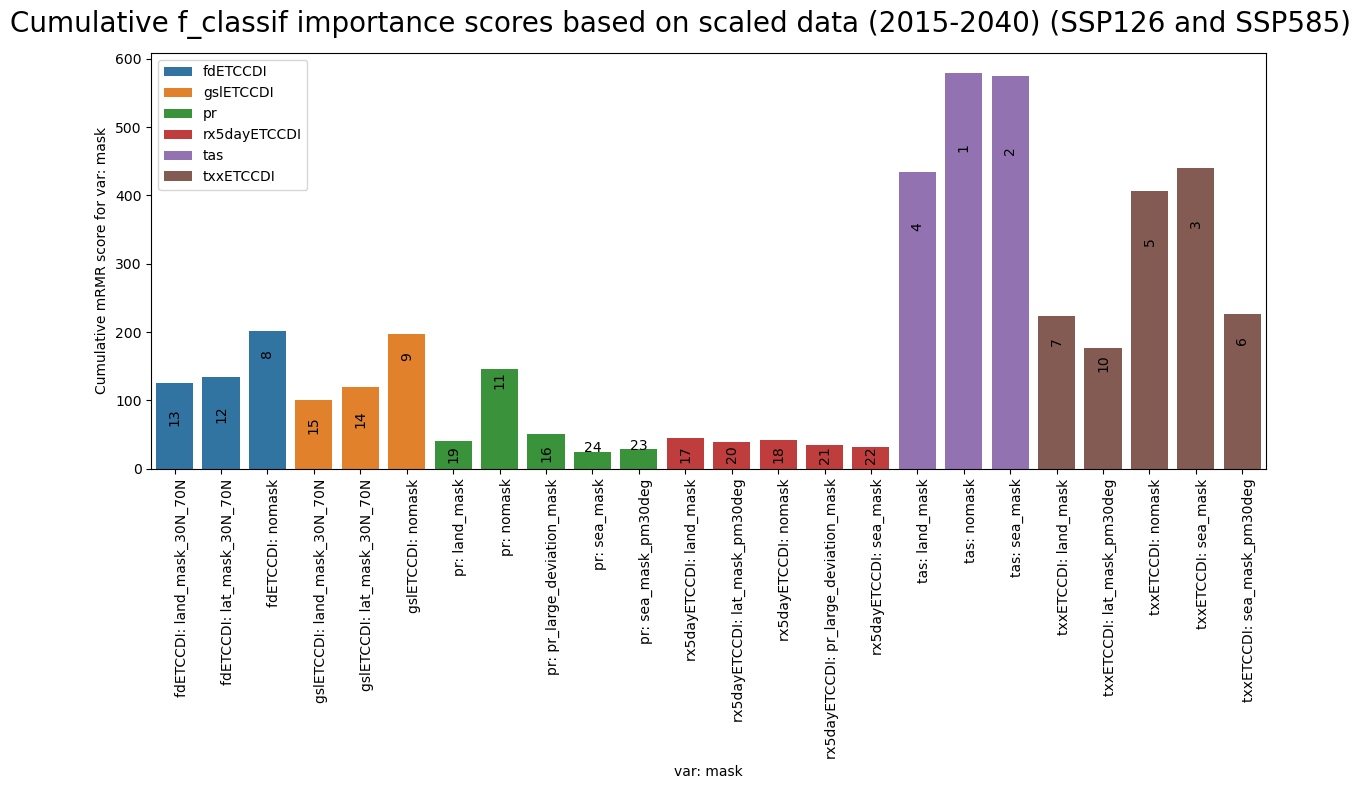

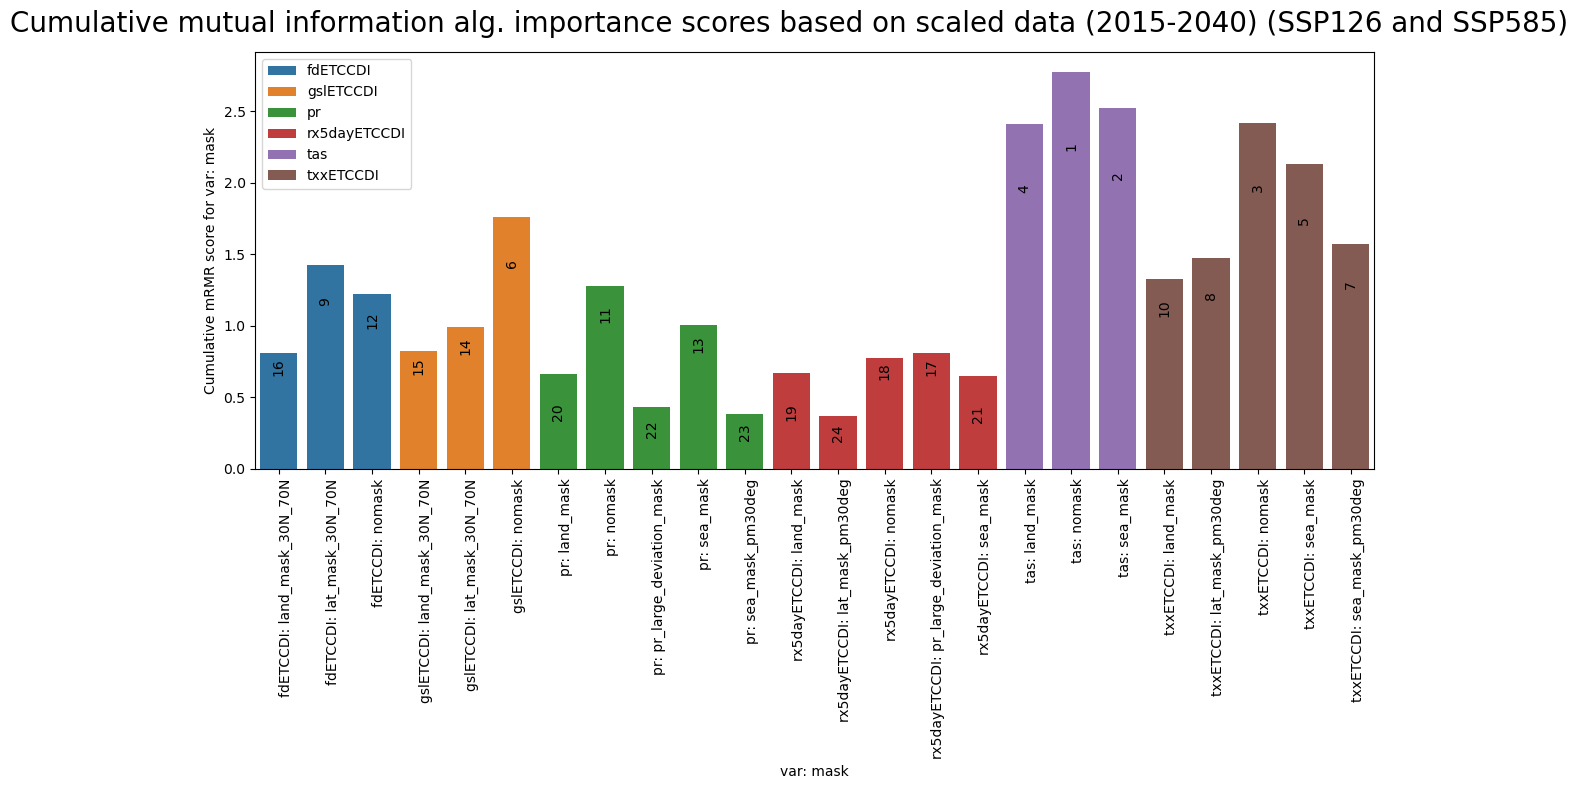

In [17]:
f_score_df = pd.read_csv('/nird/home/johannef/Masterthesis_S23 DataFiles/tables/feature_selection/f_scores_ssp126ssp585.csv')
mut_info_score_df = pd.read_csv('/nird/home/johannef/Masterthesis_S23 DataFiles/tables/feature_selection/mut_info_scores_ssp126ssp585.csv')

plot_cumulative_mRMR_scores(f_score_df, period=(2015, 2040), 
                            title='Cumulative f_classif importance scores based on scaled data (2015-2040) (SSP126 and SSP585)', 
                            filter_name='f_classif',
                            save=True, 
                            save_name='cumulative_f_classifimportance_scores_2015to2040_ssp126andssp585.png')
animate_scores_barplot(f_score_df, 
                       title=f'Cumulative f_classif importance scores (SSP126 and SSP585)', 
                       filter_name='f_classif', 
                       save_name=f'f_classif_scores_animation_ssp126andssp585.gif')
plot_cumulative_mRMR_scores(mut_info_score_df, period=(2015, 2040), 
                            title='Cumulative mutual information alg. importance scores based on scaled data (2015-2040) (SSP126 and SSP585)',
                            filter_name='mutual_info',
                            save=True,
                            save_name='cumulative_mutualinfoimportance_scores_2015to2040_ssp126andssp585.png')
animate_scores_barplot(mut_info_score_df, 
                       title=f'Cumulative mutual information alg. importance scores (SSP126 and SSP585)', 
                       filter_name='mutual_info', 
                       save_name=f'mutual_info_scores_animation_ssp126andssp585.gif')

## Using visual analysis of ensambles

# Assessing the feature combinations

- run MANOVA 
- rund PCA (Another use of dimensionality reduction in the context of evaluating features is for visualization: in a lower-dimensional space, it is easier to visually verify if the data is potentially separable, which helps to set expectations on the classification accuracy. In practice, we perform dimensionality reduction (e.g. PCA) over a subset of features and check how the labels are distributed in the reduced space. If they appear to be separate, this is a clear sign that high classification performance is expected when using this set of features.)